### Resolving the quantum teleportation paradox with quantum circuits 

Welcome to the code tutorial for the “Quantum Teleportation” instalment of the Paradoxes series on the Qiskit YouTube channel. In this tutorial, we’ll make sense of the quantum teleportation protocol, which lets us somehow teleport the state of an unknown quantum system from one location to another while only physically sending classical bits of information. We will implement the quantum teleportation protocol with a quantum circuit in Qiskit, and track the flow of quantum information during the protocol. 

If you haven't already, I recommend you first watch [our video](https://youtu.be/KsvNsY4cVvE) on the Qiskit YouTube channel, which explains the context of the thought experiment and provides a useful overview of the Qiskit code we’ll use to simulate it in this tutorial. I also suggest reading the blog post (link coming soon) for a deeper look at the background of the thought experiment.

Let's summarize the thought experiment, simulating each step using Qiskit code:

### Some background 

In 1993, a group of quantum scientists discovered that quantum information can somehow be transported from one location to another, by only sending classical information between them, as long as the locations share an entangled pair of qubits. They called this quantum teleportation. 

We often hear about teleportation in science fiction. Sci fi teleportation normally means that an object in one place can be transported to another place, without having to physically move from one place to another. In the quantum teleportation protocol, physical matter is not transported from one place to another. Instead, we are sending quantum information, the type of information that can be stored in qubits. 

I'll explain why quantum teleportation was named "teleportation", what makes it seem paradoxical - and a resolution that makes quantum teleportation seem much less paradoxical! 

### A story of quantum teleportation 

Let's start with a story to understand the quantum teleportation protocol, with two quantum scientists, Alice and Bob.

Imagine that Alice has a data qubit in some mystery state here in New York, and wants to send it over to Bob in Oxford:

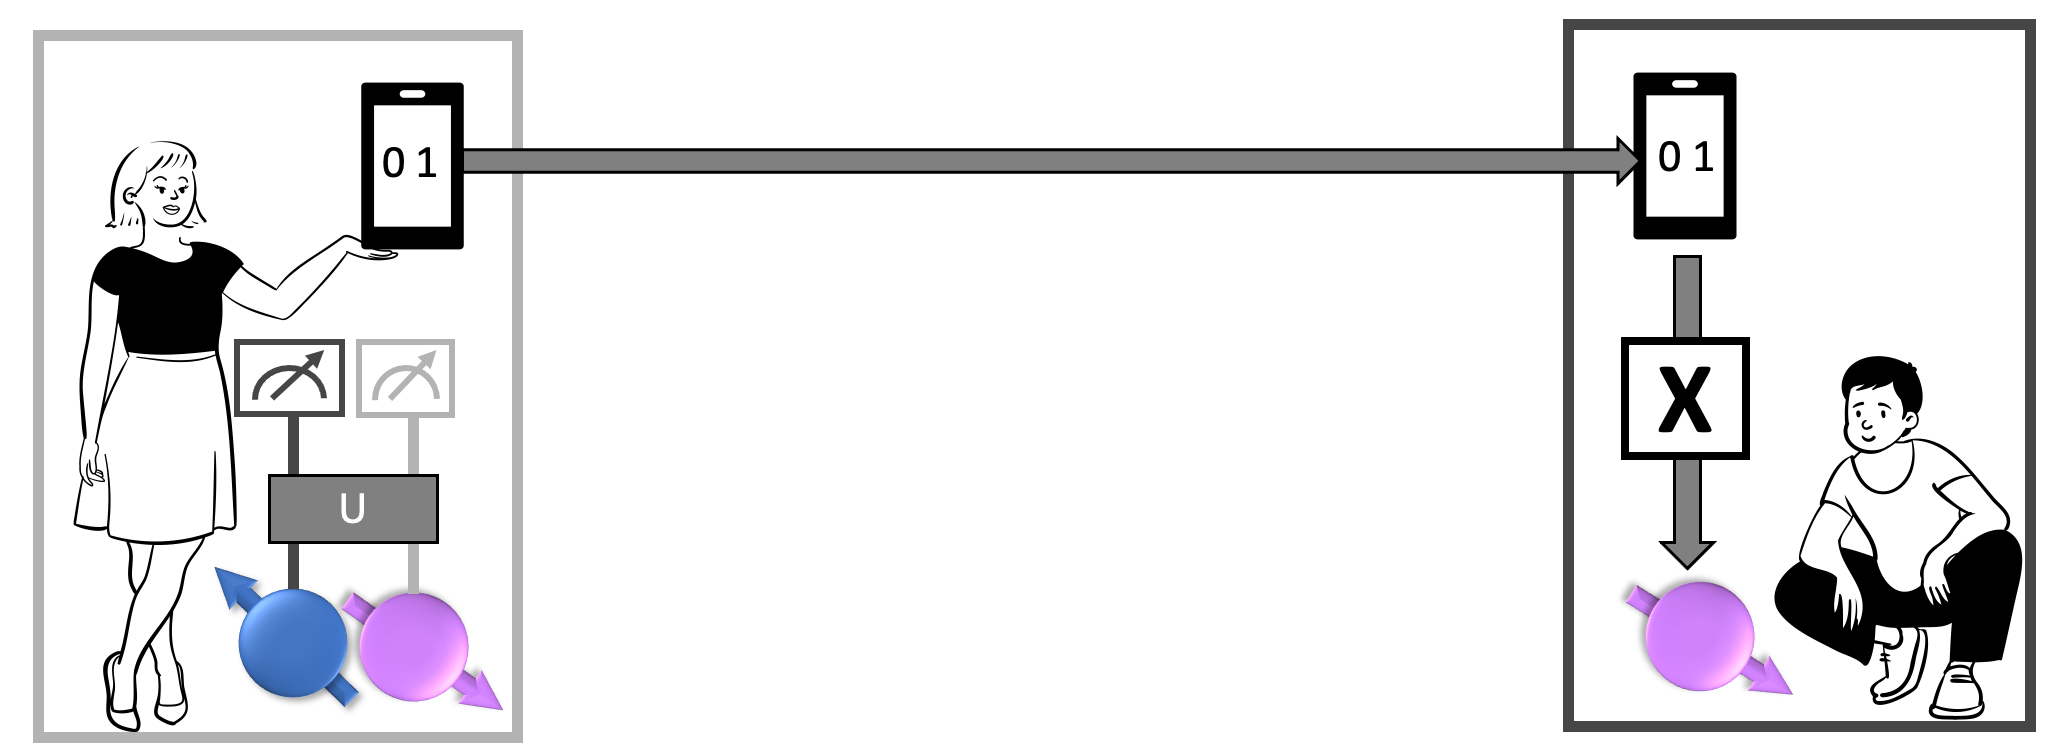

Alice and Bob share an entangled pair of qubits. 

Alice first performs a joint measurement on her data qubit and her qubit from the entangled pair. Her measurement of the two qubits will give me one of four outcomes - 00, 01, 10 or 11. Her measurement projects the data qubit's state into 0 or 1, so she no longer has the data qubit's information in New York. 

Then she sends a text of the measurement results to Bob, and depending on which numbers he receives, he will apply one of four possible quantum operations to his qubit of the entangled pair. Then, amazingly, Bob's qubit will be in the exact state of Alice's original mystery qubit! Alice has successfully teleported her data qubit from New York to Oxford, by only physically sending 2 bits of classical information there. 

### Is it real teleportation?

The weird aspect of quantum teleportation is that we can send quantum information from one location to a distant location, but by only physically sending classical bits. This seems to give us two weird options: 
1) The classical bits can somehow carry quantum information, even though they are not quantum systems. 
or the more common view:
2) The entanglement between the pair of qubits in the different locations provides a special quantum connection between those locations, that somehow enables quantum information to be transported from one to the other. Some people refer to this as "nonlocality", because it seems that entanglement allows quantum information to be sent from one location to another without any local quantum interactions taking place directly between those locations.

So even though we do are still sending something physical from one location to another with Alice's text message, it seems like Alice's quantum information is teleported to Bob - hence the name "quantum teleportation" for this protocol. 

Quantum teleportation may seem paradoxical, but I'm now going to show you how you can actually teleport qubits yourself by coding a quantum circuit that you can run on a quantum computer. Then I'll explain an approach to quantum information that lets us track the flow of the data qubit's information step by step throughout the quantum circuit, so we can see behind the scenes how quantum teleportation really works, and resolve the apparent paradox. 

### Explaining the quantum circuit 

Here's the quantum circuit for the quantum teleportation protocol, for two people in distant labs, Alice and Bob. All the qubits are initialized as 0.

First there is a Hadamard and CNOT to entangle Alice and Bob's qubits, before they are sent to each of their seperate labs. Then I've added a random unitary gate, to prepare Alice's data qubit in some unknown state that she wants to teleport to Bob.

Next, Alice does the joint Bell measurement on her data qubit and her entangled qubit, which I've implemented by applying a CNOT, Hadamard and two Z-measurements. 

Alice then has two bits of classical information, which she texts to Bob, stored on the classical registers. Next, Bob reads her text. The gates he applies to his qubits are then conditioned on the outcomes of Alice's measurement:

If the the text says 00, then Bob does nothing to his qubit. 
If the text 01, he applies an X gate.
If it says 10, he applies a Z gate. 
If it says 11, he applies an X gate and then a Z gate. 

After this, Bob's qubit is now in the state that Alice's qubit was in after the unitary - so Alice's qubit has been teleported to Bob! To check this works, I applied the inverse of the preparation unitary to the final qubit, so that it will return to the $|0\rangle$ state if it was teleported correctly. Let's try it: 

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import random_unitary
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

U = random_unitary(2)
U_gate = U.to_instruction()
U_dagger_gate = U.adjoint().to_instruction()

data_q = QuantumRegister(1, "Data qubit")
alice_q = QuantumRegister(1, "Alice's entangled qubit")
bob_q = QuantumRegister(1, "Bob's qubit")
alice_c1 = ClassicalRegister(1, "Alice's measurement 1")
alice_c2 = ClassicalRegister(1, "Alice's measurement 2")
bob_c = ClassicalRegister(1, "Bob's measurement")

qc = QuantumCircuit(data_q, alice_q, bob_q, alice_c1, alice_c2, bob_c)

qc.h(alice_q[0])
qc.cx(alice_q[0], bob_q[0])
qc.barrier()  
qc.append(U_gate, [data_q[0]])
qc.barrier()  
qc.cx(data_q[0], alice_q[0])
qc.h(data_q[0])
qc.measure(data_q[0], alice_c1[0])
qc.measure(alice_q[0], alice_c2[0])
qc.barrier()
qc.x(bob_q[0]).c_if(alice_c2, 1)
qc.z(bob_q[0]).c_if(alice_c1, 1)
qc.barrier()
qc.append(U_dagger_gate, [bob_q[0]])

qc.measure(bob_q[0], bob_c[0])

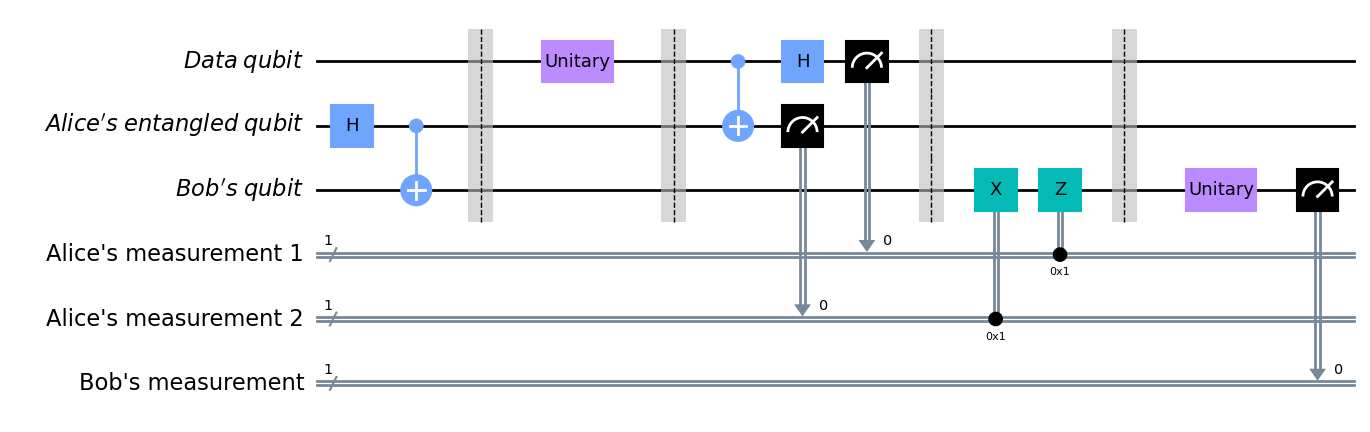

In [2]:
qc.draw("mpl")

{'0': 1024}


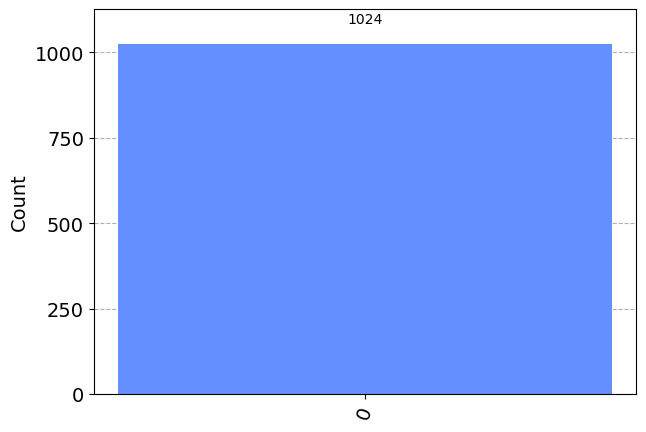

In [3]:
from qiskit.result import marginal_counts

simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit)
result = job.result()
counts = result.get_counts()

marginal_result = marginal_counts(result.get_counts(), indices=[2])
print(marginal_result)
plot_histogram(marginal_result)

We can see in the histogram that Bob's qubit is always measured to be 0, indicating that the teleportation was successful! 

### Experimental implementations 

We can run our Qiskit implementation on real IBM quantum devices.

Quantum teleportation has also been experimentally implemented for qubits based in distant locations. There are quantum networking techniques to produce entangled pairs of qubits in seperate labs, for example, by sending an entangled pair of photons to both labs via an optical fibre.

### Gate teleportation

Quantum teleportation is also incredibly useful for quantum computing. We can modify the quantum teleportation protocol to perform gate teleportation, where instead of directly applying a quantum gate to our data qubit, we can prepare our entangled qubits in a particular state. Then when we let them interact with the data qubit, and apply the right corrections to the other entangled qubit, the teleported qubit has the gate applied to it automatically. 

### Resolving the paradox 

So we know that teleporting quantum information just by sending bits of classical information, and having access to entanglement, really works! How does this make any sense? 

To track the flow of information during quantum teleportation, we need to use the local formulation of quantum theory, which reveals how information is locally stored in qubits, even when they are entangled. 

If you haven't already, then I recommend watching [my previous video](https://youtu.be/eoPX4WJlOM8?si=G7nIMpnHnygHmExX) on the local explanation for entanglement in the Einstein-Podolsky-Rosen paradox. 

The punchline is that when we use a description of quantum mechanics called the Heisenberg picture, then we can track the full description of individual quantum states using their observables. Very importantly, when describing systems using their observables, doing a quantum operation on one system cannot change the observables of a seperate system, even if they are entangled. This means that a system can only have some dependence on the properties of another system if they have a direct interaction. 

To track the flow of information, we also need to use the technique from previous videos (e.g. the video on [Schrödinger's cat](https://youtu.be/sBtAe8BsOhA?si=JYqT3xJkcG1HvfII)) of treating measurement devices themselves as quantum systems. Alice's classical detector register becomes a quantum register, and the measurements are implemented by CNOT gates, such that a measurement outcome of 0 will cause Alice's detector qubit to stay in the 0 state, and a measurement outcome of 1 will cause Alice's detector qubit to change to the 1 state. In quantum computing, the principle of deferred measurement ensures that if we change measurements at the end of a circuit for CNOT gates it will make no difference to the final outcomes. 

Let's see what happens to our quantum circuit if we turn Alice's measurement device into a quantum system: 

In [4]:
alice_detector_q = QuantumRegister(2, "Alice's detector")

qc = QuantumCircuit(data_q, alice_q, bob_q, alice_detector_q, bob_c)

qc.h(alice_q[0])
qc.cx(alice_q[0], bob_q[0])
qc.barrier()  
qc.append(U_gate, [data_q[0]])
qc.barrier()  
qc.cx(data_q[0], alice_q[0])
qc.h(data_q[0])

qc.barrier()
qc.cx(alice_q[0], alice_detector_q[1])
qc.cx(data_q[0], alice_detector_q[0])

qc.barrier()
qc.cx(alice_detector_q[1], bob_q[0])
qc.cz(alice_detector_q[0], bob_q[0])

qc.append(U_dagger_gate, [bob_q[0]])

qc.measure(bob_q[0], bob_c[0])

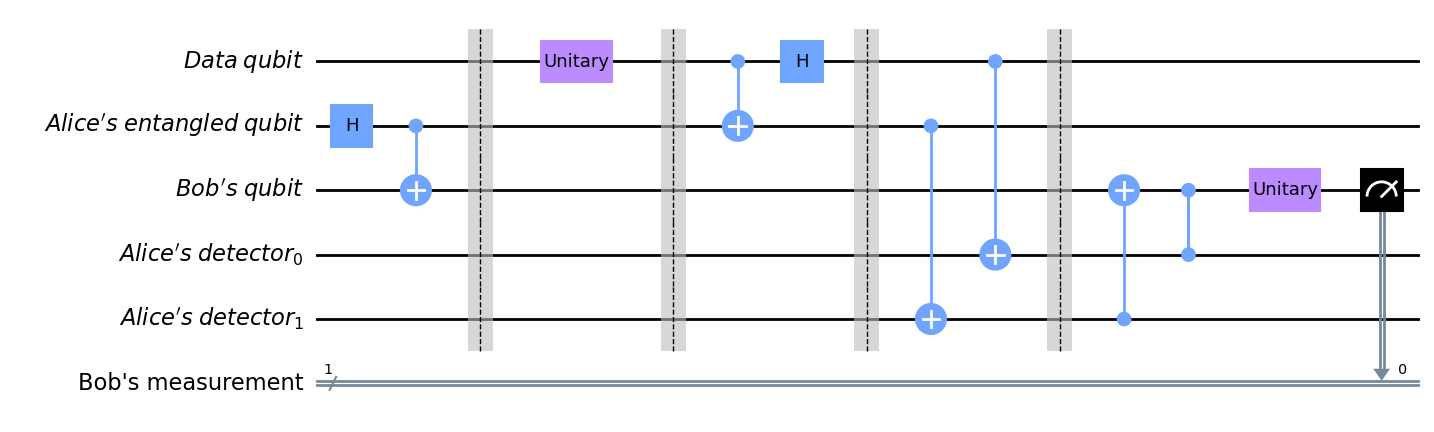

In [5]:
qc.draw("mpl")

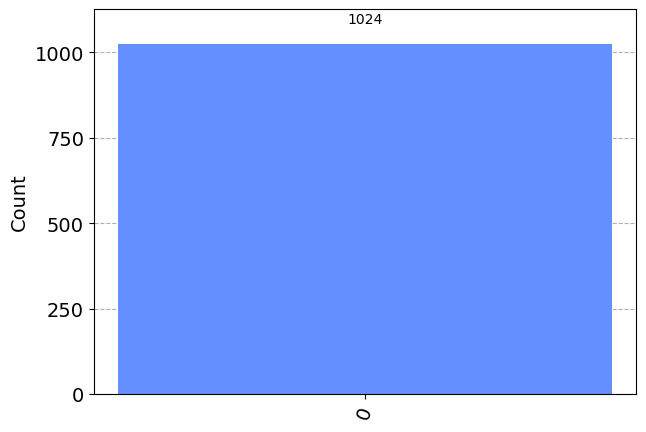

In [6]:
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

As before, Bob's qubit is always measured to be 0, indicating that Alice's data qubit was successfully transported to Bob! 

### Tracking local information flow 

Let's track the information flow of the data qubit in this picture:

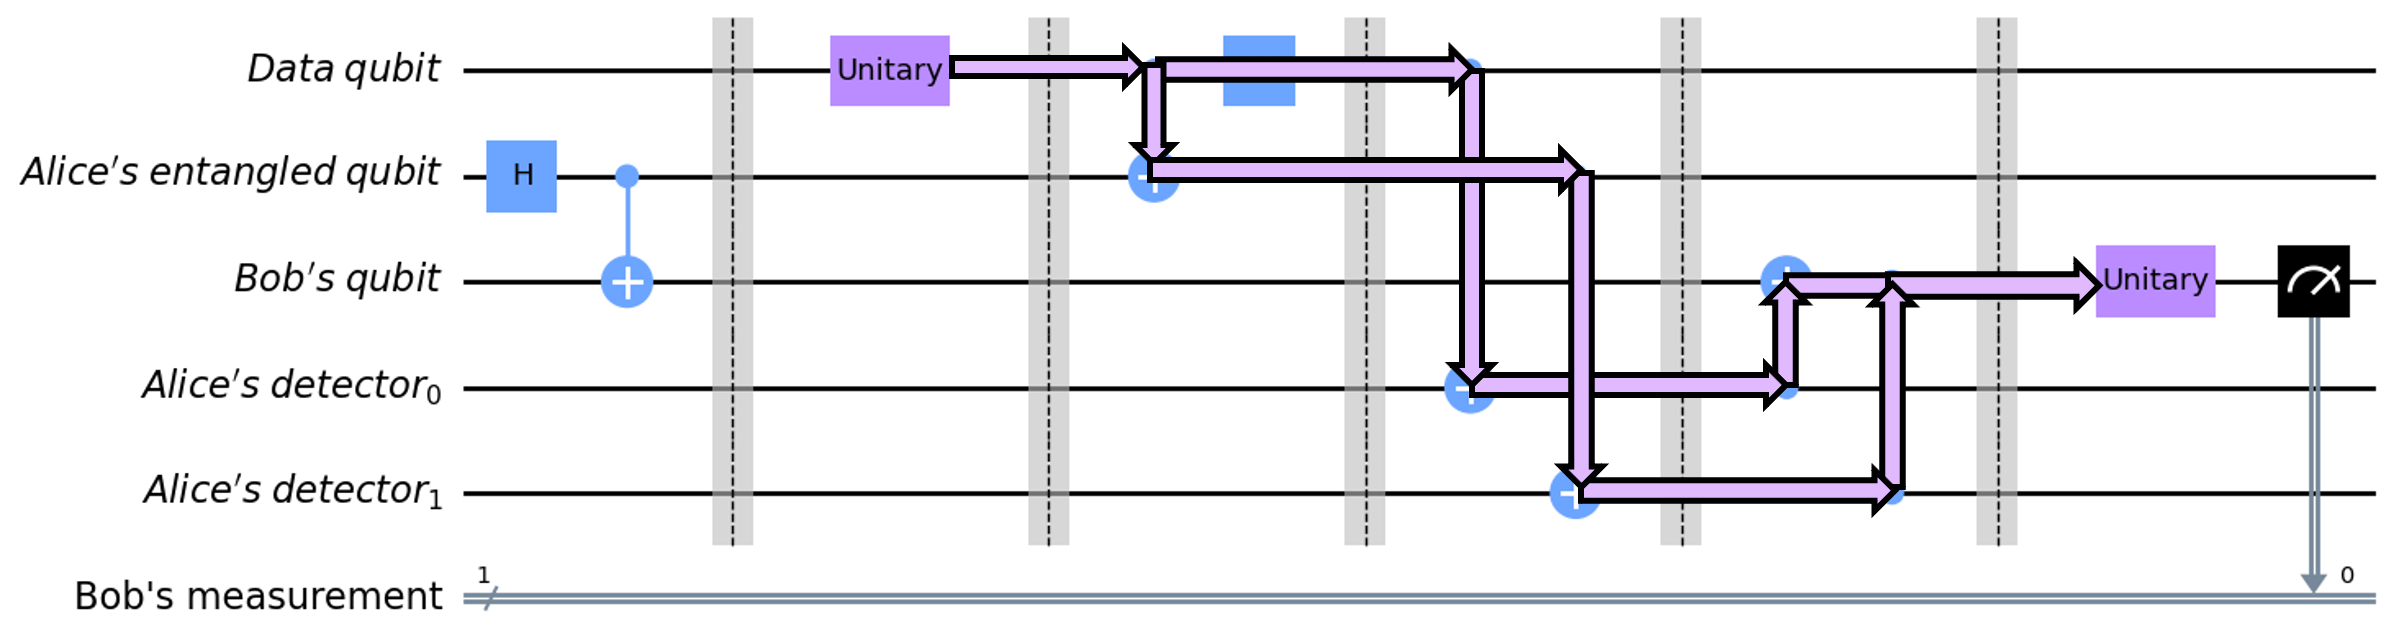

It starts localised on Alice's qubit. Then there is a direct interaction between the data qubit and Alice's entangled qubit via a CNOT gate, so Alice's entangled qubit can also depend on the data. Next, there is a direct CNOT gate between the data qubit and Alice's detector qubit, and between Alice's entangled qubit and second detector qubit. These direct interactions mean that Alice's detector qubits can now depend on the initial state of the data qubit. Finally, there are CNOT and CZ gates implementing direct interactions between Alice's detector qubits and Bob's qubit, meaning that Bob's qubit can now depend on the initial state of the data qubit.   

So we see that the data qubit information can be tracked step by step throughout the circuit. 

A consequence of the local picture is that qubits must be able to contain some locked-up information, that we call locally inaccessible information. This means that even if we had infinite copies of the qubit to measure, there's some information that it contains that we can't extract from measurements on that qubit alone. 

I've shown the point where the information becomes locked-up in Red on the quantum circuit here: 

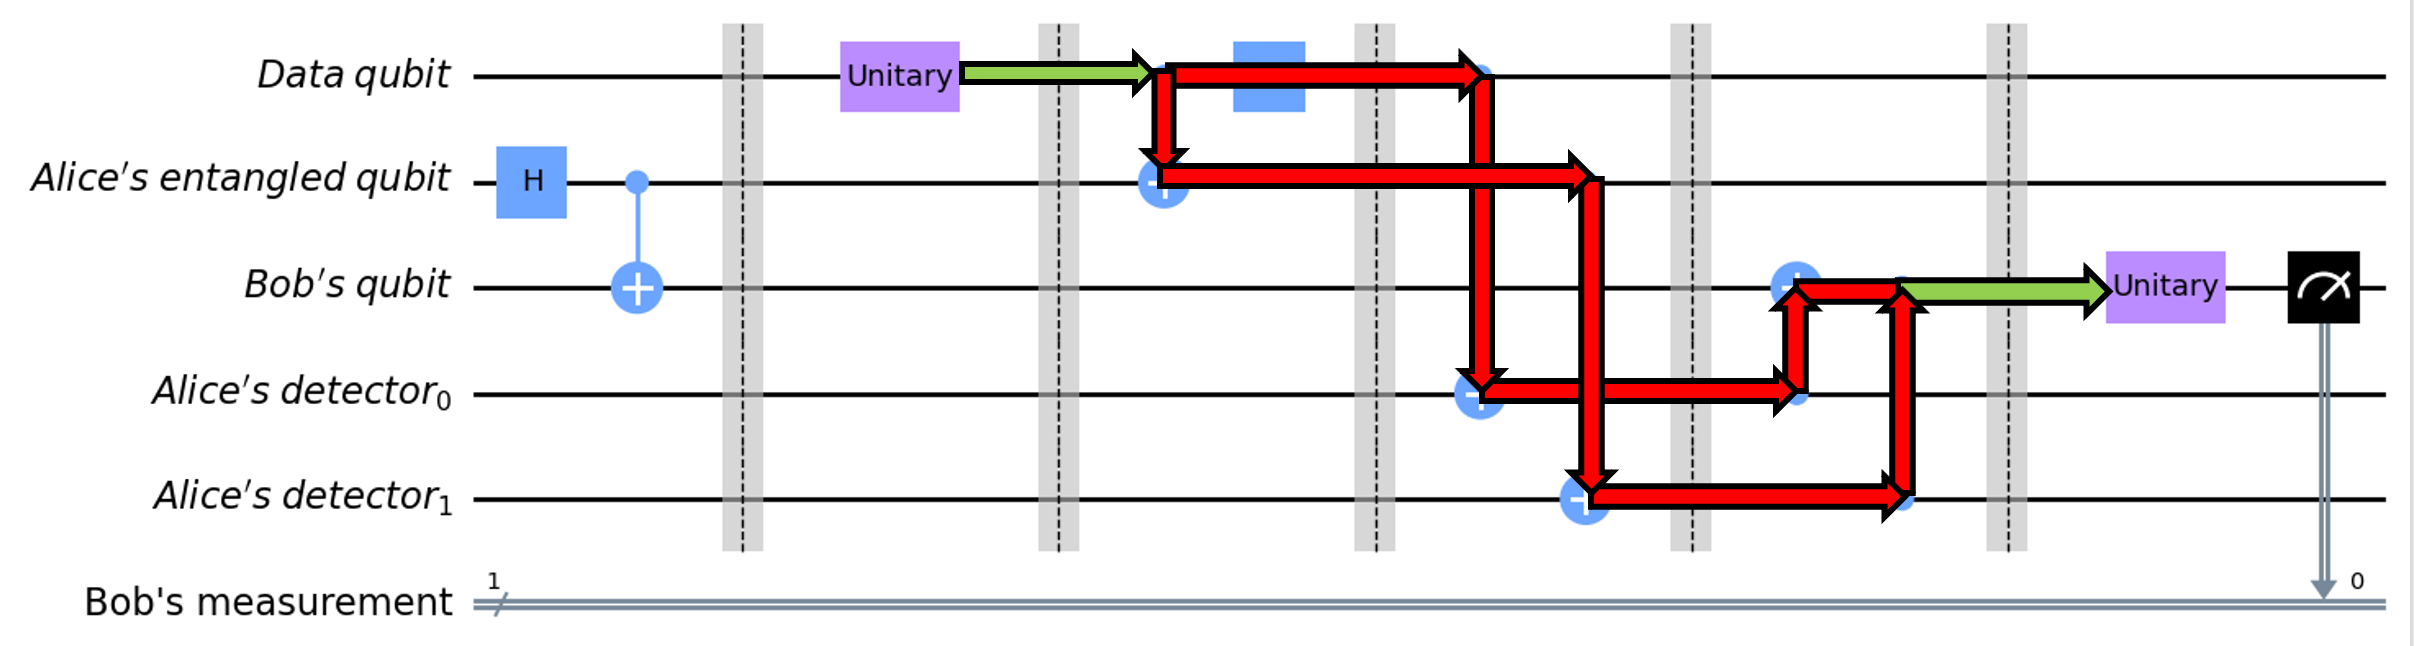

In this circuit, the CNOT on the data qubit and Alice's entangled qubit converts the data qubit's information so that it is stored in a locally inaccessible way in those two qubits. It remains locally inaccessible in Alice's detector qubits, and only becomes accessible when Alice's detector qubits directly interact with Bob's entangled qubit. Bob's entangled qubit therefore acts as a "key" to give access to the information that was "locked-up" in Alice's detector qubits. 

This information isn't shown in the reduced density matrix of one of the entangled qubits, which describes the qubits state using the Schrodinger picture. We have to describe its state using the Heisenberg picture of quantum theory to explicitly show that the qubit contains this hidden information. 

The great thing about having the data qubit information fully locked up in Alice's detector qubit, is that it is also robust to decoherence: measurements can't retreive it, but they also can't destroy it! In this approach, the classical bits that Alice sends to Bob are really just qubits that are constantly being measured. What appeared to be classical bits sent from Alice to Bob are actually quantum bits in disguise, moving the locked-up physical quantum information from one location to another. 

### Teleportation in a textbook?

This local formulation does not appear in typical textbook explanations of quantum teleportation, which often don't offer any explanation for how entanglement enables quantum information to be transported by classical bits. Some researchers object to the local formulation and it remains an active topic of debate. The recent paper [Teleportation Revealed](https://arxiv.org/pdf/2304.14959.pdf), by Charles Bédard, explains the local approach in detail, including a discussion section to clarify points of confusion. It also mentions that one of the original creators of quantum teleportation and recent winner of the Breakthrough Prize, Gilles Brassard, found this to be "the most satisfactory elucidation of teleportation that he had ever heard".

If you'd like to understand the maths behind the quantum teleportation circuit, take a look at the ["teleportation analysis"](https://www.youtube.com/watch?v=GSsElSQgMbU&t=1035s) section of Lesson 4 of the Understanding Quantum Information and Computation series. Quantum teleportation is also neatly described using the diagramatic formalism of quantum mechanics [based on ZX calculus](https://arxiv.org/pdf/2303.03163.pdf). 

I hope you've enjoyed experiencing the wonder of quantum teleportation - which unlike sci fi telelportation, you can genuinely implement yourself on a quantum computer by writing some code. In the next installment, we will be entering the even stranger realms of quantum time-loops, and you'll find out how quantum circuits can help us resolve famous time-travel paradoxes. 